In [183]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import time
plt.style.use('dark_background')

Interesting details on weight initialization https://pouannes.github.io/blog/initialization/

Use Kaiming method 

"The Kaiming paper accordingly suggests to initialize the weights of layer l with a zero-mean Gaussian distribution with a standard deviation of sqrt(s/Nl) , and null biases."

Nl is the number of neurons in layer l

In [184]:
def relu(number):
    """
    Returns the ReLU of a number
    ReLU function is 0 for all negative inputs, and f(x) = x for all x >= 0
    """
    return max(0, number)

In [185]:
class Neuron:
    """
    Neuron class for neural network
    Each neuron is a node in the network
    Can be organized into layers with Layer class
    Each Neuron has a list of Neurons coming in (the upstream neurons in the network)
    and a list of Neurons going out (the downstream neurons in the network)
    The weights correspond to the list of input Neurons
    ex. a Neuron with 5 upstream neurons will have 5 weights, one for each input
    Bias determines a Neurons tendency to be off/on
    """
    def __init__(self, activation=0.5, inNeurons=[], outNeurons=[], weights=[], bias=0):
        """
        Constructor for Neuron class
        """
        self.inNeurons = inNeurons
        self.outNeurons = outNeurons
        self.activation = activation
        self.weights = weights
        self.bias = bias
        
    def addIn(self, n, weight):
        """
        Adds input neuron with provided weight
        Used in Layer class to connect Layers
        """
        self.inNeurons.append(n)
        self.weights.append(weight)
        
    def addOut(self, neuron):
        """
        Adds output neuron
        Used in Layer class to connect Layers
        """
        self.outNeurons.append(neuron)
    
    def getActivation(self):
        """
        Returns activation of Neuron
        """
        return self.activation
    
    def setActivation(self, a):
        """
        Sets activation of Neuron to a
        Returns a
        """
        self.activation = a
        return a
    
    def getBias(self):
        """
        Returns bias of Neuron
        """
        return self.bias
    
    def setBias(self, b):
        """
        Sets bias of Neuron to b
        Returns b
        """
        self.bias = b
        return b


class Layer:
    """
    Layer class for neural network
    Layers are collections of neurons
    Layers can be linked together to form networks
    """
    def __init__(self, neurons=[], generate=True, size=0):
        """
        Constructor for Layer class
        Can input a list of neurons to build layer, or randomly generate
        neurons for layer of desired size
        """
        self.neurons = neurons.copy()
        print("Initializing Layer")
        
        #  Generates the neurons for the layer
        if generate and len(self.neurons) == 0:
            for i in range(size):
                self.neurons.append(Neuron())
        
        print("Created layer of size %d" % len(self.neurons))
        
        #  Initializes attributes
        self.size = size
        self.upLayer = None
        self.downLayer = None
        self.weights = None
        self.weightsSet = False
        self.desiredOut = []
        self.z = []  #  Pre-ReLU activations
        
        #  Records activations and biases of neurons in layer
        self.biases = np.array(list(map(Neuron.getBias, self.neurons)))
        self.activations = np.array(list(map(Neuron.getActivation, self.neurons)))
    
    def setActivations(self, actList):
        """
        Sets activations of neurons in layer to actList
        """
        #  Checks to ensure provided activation list is the appropriate size
        if len(actList) == self.size:
            for i in range(self.size):
                self.neurons[i].setActivation(actList[i])
            self.activations = actList
        else:
            raise Exception("Invalid activation list length")
                
    
    def getActivations(self):
        """
        Returns activations of Neurons in Layer
        """
        return self.activations
    
    def getBiases(self):
        """
        Returns biases of Neurons in Layer
        """
        return self.biases
    
    def getSize(self):
        """
        Returns number of Neurons in Layer
        """
        return self.size
    
    def downstreamConnect(self, down, weights=None):
        """
        Connects neuron layer "down" to self 
        Connection is such that "down" is downstream in the neural network
        Unless specified, weight matrix is initialized randomly within Kaiming distribution
        layer1.upstreamConnect(layer2) is equivalent to layer2.downstreamConnect(layer1)
        IMPORTANT NOTE: WEIGHT MATRIX MIGHT NOT PROPERLY FOLLOW KAIMING
        INSTEAD THEY SAMPLE RANDOMLY FROM A GAUSSIAN DISTRIBUTION WITH VARIANCE DETERMINED BY KAIMING
        MAY CAUSE PROBLEMS WITH SMALL LAYERS, POSSIBLY NEEDS FIX LATER
        """
        upLayerNeurons = self.neurons
        downLayerNeurons = down.neurons
        
        if not weights:
            #  Create random weight initialization matrix
            #  Weights are picked randomly from gaussian of mean=0 and variance according to Kaiming
            weightVariance = np.sqrt(2/len(upLayerNeurons))
            weights = np.random.normal(scale=weightVariance, size=(down.getSize(), self.getSize()))
            print("Created %d by %d weight matrix" % weights.shape)
            down.weightsSet = True
            
        for d in range(down.getSize()):
            for u in range(self.getSize()):
                #  Connect all Neurons between the Layers
                #  Set weights of Neurons in downstream Layer
                upLayerNeurons[u].addOut(downLayerNeurons[d])
                downLayerNeurons[d].addIn(upLayerNeurons[u], weights[d, u])
        
        #  Set weight matrix of downstream Layer and mark up/downstream connections
        down.weights = weights  #  This should be a method like updateWeights(), might be useful later
        down.upLayer = self
        self.downLayer = down
        self.update()
        
        return weights
    
    def upstreamConnect(self, up):
        """
        IMPLEMENTATION INCOMPLETE
        Connects neuron layer "up" to self 
        Connection is such that "up" is upstream in the neural network
        layer1.upstreamConnect(layer2) is equivalent to layer2.downstreamConnect(layer1)
        """
    
    def updateZ(self):
        """
        Updates Neuron pre-ReLU activations based on weight matrix, 
        biases and activations of upstream Layer
        """
        #  Only update if weights had been set
        if self.weightsSet:
            #  Update pre-ReLU activations
            self.z = np.matmul(self.weights, self.upLayer.getActivations())
            self.z = np.subtract(self.z, self.biases)
            
    def update(self):
        """
        Updates Neuron activations based on weight matrix, biases and activations of upstream Layer
        """
        #  Only update if weights had been set
        if self.weightsSet:
            #  Update pre-ReLU activations
            self.z = np.matmul(self.weights, self.upLayer.getActivations())
            self.z = np.subtract(self.z, self.biases)
            #  Update activations
            newActivations = np.array(list(map(relu, self.z)))
            self.setActivations(newActivations)


In [316]:
class NN:
    """
    Neural Network class
    A NN consists of Neuron Layers, connected in a linear manner
    End Layers act as data input and output
    Middle Layers each have upstream and downstream connections
    and serve as NN's hidden Layers
    """
    def __init__(self, numLayers, layerSizes):
        """
        Constructor for NN class
        numLayers is an integer that determines the number of Layers in the NN
        layerSizes is a list or tuple of length numLayers that determines the
        number of Neurons in each layer, with layerSizes[0] being the size of the input layer
        """
        assert(numLayers == len(layerSizes))
        self.numLayers = numLayers
        self.layerSizes = layerSizes
        print("Creating Neural Network with %d layers" % numLayers)
        self.layers = []
        self.desiredOut = []
        self.lRate = 0.0002
        
        #  Create layers and connect them
        for i in range(numLayers):
            self.layers.append(Layer(size=layerSizes[i]))
            if i > 0:
                #  No downstream connection for the last layer
                self.layers[i-1].downstreamConnect(self.layers[i])
            self.layers[i].updateZ()
        print("Neural Network Initialized")
        
    def inputData(self, dataIn, dataOut):
        """
        Sets input layer activations to dataIn if data is the proper size
        Saves dataOut as desired output if data is the proper size
        Otherwise raises Exception
        """
        if self.layers[0].getSize() == len(dataIn) and self.layers[-1].getSize() == len(dataOut):
            self.layers[0].setActivations(dataIn)
            self.desiredOut = dataOut
            self.layers[-1].desiredOut = dataOut
        else:
            raise Exception("Invalid data size")
            
    def getCost(self):
        """
        Returns resulting cost of current NN configuration based on desired output
        """
        return np.sum(np.square(np.subtract(self.layers[-1].getActivations(), self.layers[-1].desiredOut)))
    
    def backprop(layer):
        """
        """
        #  dCost0/daK(L-1) = dz0(L)/daK(L-1) * da0(L)/dz0(L) * dC0/da0(L)
        #  dCost/da(L-1) K = sum dCostJ/daK(L-1)
        #  z(L) is pre-ReLU activations, a(L) is activations of Layer L
#         size = layer.getSize()
        upSize = layer.upLayer.getSize()
        gradient = np.ndarray(upSize)
#         upAct = layer.upLayer.getActivations()
        act = layer.getActivations()
        actZPartial = np.where(layer.z >= 0, 1, 0)
        #  Iterate through each activation in the previous layer, calculating the partial of the cost function
        #  with respect to each one
#         for k in range(upSize):
#             costPartial = 0
#             for j in range(size):              
#                 costPartial += 2 * (act[j] - layer.desiredOut[j]) * layer.weights[j][k] * actZPartial[j]
#             gradient[k] = costPartial
        #  Calculate gradient wrt upstream activations
        #  masked is the error between activations and desired activations, masked by the binary actZPartial
        #  This masked array can then be matric multiplied with the transpose of weights to get the gradient
        masked = np.multiply(np.subtract(act, layer.desiredOut), actZPartial)
        gradient = 2 * np.matmul(np.transpose(layer.weights), masked)
        #print("current activation: %s" % layer.upLayer.getActivations())
        #print("activation gradient: %s" % gradient)
        layer.upLayer.desiredOut = np.subtract(layer.upLayer.getActivations(), gradient)
        #print("new desired activation: %s" % layer.upLayer.desiredOut)
    
    def gradientDescentWeights(self, layer):
        """
        Finds the vector for gradient descent of weights of a Layer and subtracts 
        this vector from that Layer's weights
        Returns the vector
        """
        #  dCost/dWeights(L) = dz(L)/dw(L) * da(L)/dz(L) * dC/da(L)
        #  z(L) is pre-ReLU activations, a(L) is activations of Layer L
        size = layer.getSize()
        upSize = layer.upLayer.getSize()
        gradient = np.ndarray(shape=(size, upSize))
#         upAct = layer.upLayer.getActivations()
        upAct = np.reshape(np.array(layer.upLayer.getActivations()), (1, -1))
        act = layer.getActivations()
        actZPartial = np.where(layer.z >= 0, 1, 0)     
        #  Iterate through each weight, calculating the partial of the cost function
        #  with respect to each one
        
        row = np.reshape(np.array(self.lRate * 2 * np.multiply(np.subtract(act, layer.desiredOut), actZPartial)), (-1, 1))
        gradient = upAct * row
#         print(gradient)
#         for k in range(upSize):
#             for j in range(size):
#                 gradient[j][k] = row[j] * upAct[k]
#                 gradient[j][k] = self.lRate * 2 * (act[j] - layer.desiredOut[j]) * upAct[k] * actZPartial[j]

#         print("current weights: %s" % layer.weights)
#         print("weight gradient: %s" % gradient)
        layer.weights = np.subtract(layer.weights, gradient)
#         print("new weights: %s" % layer.weights)
        
    def gradientDescentBiases(layer):
        """
        """
        #  dCost/dBiases(L) = dz(L)/db(L) * da(L)/dz(L) * dC/da(L)
        #  z(L) is pre-ReLU activations, a(L) is activations of Layer L
        actZPartial = np.where(layer.z >= 0, 1, 0)
        size = layer.getSize()
        gradient = np.ndarray(size)
        
        for j in range(size):
            act = layer.getActivations()
            gradient[j] = 2 * (act[j] - layer.desiredOut[j]) * actZPartial[j]
        #print("bias gradient: %s" % gradient)
        layer.biases = np.subtract(layer.biases, gradient)
        #print("new biases: %s" % layer.biases)
    
    def showStructure(self):
        """
        Prints out the number of layers in the NN
        Prints out the sizes of each layer
        """
        print("The network is contains %d layers" % self.numLayers)
        print("The layer sizes are %s" % self.layerSizes)
        
    def updateActivations(self):
        """
        Updates activations of all Neurons in all Layers in NN according
        to their weights and the activations of their upstream Layer
        """
        #  Input layer is skipped, as it has no upstream layer
        for layer in self.layers[1:]:
            layer.update()
            
    def showActivations(self):
        """
        Displays activations of each Layer of the NN
        """
        for i in range(self.numLayers):
            print(self.layers[i].getActivations())
    

In [341]:
nn = NN(4, [100, 50, 10, 10])
nn.showStructure()
nn.showActivations()

Creating Neural Network with 4 layers
Initializing Layer
Created layer of size 100
Initializing Layer
Created layer of size 50
Created 50 by 100 weight matrix
Initializing Layer
Created layer of size 10
Created 10 by 50 weight matrix
Initializing Layer
Created layer of size 10
Created 10 by 10 weight matrix
Neural Network Initialized
The network is contains 4 layers
The layer sizes are [100, 50, 10, 10]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.         0.90066114 0.         0.         0.         0.78307904
 0.         0.16923808 1.09836061 0.         0.         0.
 0.         0.16705863 0.         0.         0.         0.14

Time: 84.77616167068481 seconds


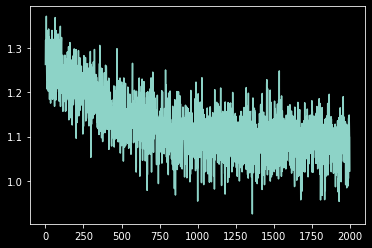

In [343]:
nn.lRate = 0.00005
batchSize = 100
epochs = 2000
avgs = []

start = time.time()
for i in range(epochs):
    totalCost = 0
    for j in range(batchSize):
        dataIn = np.random.uniform(size=100)
        dataOut = [dataIn[i] for i in range(0, 100, 10)]
        nn.inputData(dataIn, dataOut)
        nn.updateActivations()
        for k in range(nn.numLayers-1, 1, -1):
            nn.gradientDescentWeights(nn.layers[k])
            NN.backprop(nn.layers[k])
        nn.gradientDescentWeights(nn.layers[1])
#         nn.gradientDescentWeights(nn.layers[-1])
#         NN.backprop(nn.layers[-1])
#         nn.gradientDescentWeights(nn.layers[2])
#         NN.backprop(nn.layers[2])
#         nn.gradientDescentWeights(nn.layers[1])
        #print("cost: %s" % nn.getCost())
        totalCost += nn.getCost()
#     print(totalCost/batchSize)
    avgs.append(totalCost/batchSize)
duration = time.time() - start

print("Time: %s seconds" % duration)
plt.plot(list(range(epochs)), avgs)

In [338]:
dataIn = np.random.uniform(size=100)
dataOut = [dataIn[i] for i in range(0, 100, 10)]
nn.inputData(dataIn, dataOut)
nn.updateActivations()
print(nn.layers[-1].desiredOut)
print(nn.layers[-1].getActivations())
nn.gradientDescentWeights(nn.layers[-1])
#NN.updateDesiredActivationsUp(nn.layers[-1])
#NN.gradientDescentWeights(nn.layers[1])
#NN.gradientDescentBiases(nn.layers|[-1])

[0.7496483116812949, 0.3795383907564551, 0.8043755404404884, 0.5582491266468234, 0.6097291754713159, 0.35969639269389975, 0.3989955881137722, 0.3801805288121395, 0.5789456368887715, 0.36965463967687384]
[0.74431419 0.57032154 0.87416323 0.79332334 0.57339332 0.18446189
 0.78191813 0.         0.16883238 0.46284372]


In [314]:
nn.layers[2].weights

array([[ 1.50992608e-01,  7.71871119e-01, -3.59951378e-01,
         1.99940210e-01,  9.11822405e-02,  2.09655759e-01,
        -1.81324625e-01, -6.36865342e-02,  6.85858604e-01,
        -6.30659440e-02,  2.81986583e-01,  7.58628073e-02,
        -5.42183536e-02, -8.95330716e-02,  2.31188873e-01,
        -3.65784663e-01,  9.58517783e-02,  1.92803285e-01,
        -2.67876313e-01, -3.12493933e-01],
       [ 7.23204345e-02,  1.36595975e-01, -1.95444486e-02,
        -2.62694884e-01, -6.46078748e-02, -1.46146142e-01,
        -3.11278218e-01, -4.23603707e-01,  1.42612290e-01,
        -2.26814948e-01, -1.02851194e-01, -1.61624449e-01,
         1.01032416e-01, -1.85176934e-01,  4.84538118e-01,
         1.43089583e-01, -1.53998347e-01, -5.66920613e-01,
        -7.00358434e-01,  1.20744329e-02],
       [ 6.25626674e-01,  2.98681553e-02, -4.11871363e-01,
        -1.49431732e-01, -7.82318598e-03, -6.02319643e-02,
         1.91182643e-01,  2.53430917e-01, -8.69987711e-02,
        -1.94663536e-01, -2.5

In [315]:
nn.layers[1].getActivations()

array([0.        , 1.62528255, 1.33213358, 0.        , 0.        ,
       1.42753889, 2.54358913, 0.7513953 , 0.        , 1.57140079,
       1.79863713, 0.32281664, 1.57558113, 0.54629096, 0.        ,
       0.        , 1.33712701, 1.53911227, 0.        , 0.95400028])

In [10]:
dataIn = 2*list(np.linspace(0,0.5,50))
dataOut = dataIn

nn.inputData(dataIn, dataOut)

nn.updateActivations()
out = nn.layers[-1].getActivations()

print(dataOut)
print(out)
print(nn.layers[-1].weights[0])
print(np.dot(nn.layers[-1].weights[0], dataIn))


Exception: Invalid data size

In [ ]:
dataIn = [1, 1]*50
dataOut = dataIn
nn.inputData(dataIn, dataOut)

print("LAST LAYER")
NN.gradientDescentWeights(nn.layers[-1])
#NN.updateDesiredActivationsUp(nn.layers[-1])
#NN.gradientDescentBiases(nn.layers[-1])

nn.updateActivations()
nn.showActivations()
print("cost: %s" % nn.getCost())

dataIn = [1, 0]*50
dataOut = dataIn
nn.inputData(dataIn, dataOut)

print("LAST LAYER")
NN.gradientDescentWeights(nn.layers[-1])
#NN.updateDesiredActivationsUp(nn.layers[-1])
#NN.gradientDescentBiases(nn.layers[-1])

nn.updateActivations()
nn.showActivations()
print("cost: %s" % nn.getCost())

dataIn = [0, 1]*50
dataOut = dataIn
nn.inputData(dataIn, dataOut)

print("LAST LAYER")
NN.gradientDescentWeights(nn.layers[-1])
#NN.updateDesiredActivationsUp(nn.layers[-1])
#NN.gradientDescentBiases(nn.layers[-1])

nn.updateActivations()
nn.showActivations()
print("cost: %s" % nn.getCost())

dataIn = [0, 0]*50
dataOut = dataIn
nn.inputData(dataIn, dataOut)

print("LAST LAYER")
NN.gradientDescentWeights(nn.layers[-1])
#NN.updateDesiredActivationsUp(nn.layers[-1])
#NN.gradientDescentBiases(nn.layers[-1])

nn.updateActivations()
nn.showActivations()
print("cost: %s" % nn.getCost())
